In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re

from pandas.api.types import CategoricalDtype

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import LinearRegression

from statsmodels.graphics.tsaplots import plot_pacf
from xgboost import XGBRegressor

In [2]:
# this is for experimentation

filter_by_stores = None
filter_by_family = None
filter_by_dates = None

#filter_by_stores = [15]
#filter_by_family = ['PRODUCE']
#filter_by_dates = '2014-06-05'

In [3]:
# control parameters

max_sales_lags = 20

In [4]:
if filter_by_dates == None:
    train_start_date = '2013-01-01'
else:
    train_start_date = filter_by_dates
train_end_date = '2017-08-15'
test_start_date = '2017-08-16'
test_end_date = '2017-08-31'

train_dates = pd.DataFrame(pd.date_range(start=train_start_date, end=train_end_date), columns=['date'])
test_dates = pd.DataFrame(pd.date_range(start=test_start_date, end=test_end_date), columns=['date'])
all_dates = pd.DataFrame(pd.date_range(start=train_start_date, end=test_end_date), columns=['date'])
train_dates['date'] = train_dates['date'].dt.to_period('D')
test_dates['date'] = test_dates['date'].dt.to_period('D')
all_dates['date'] = all_dates['date'].dt.to_period('D')

In [5]:
# Read csv files

path = '../store-sales-forecasting/data/'
use_gz = True
def pathname(filename):
    if use_gz:
        return path + filename + '.csv.gz'
    else:
        return path + filename + '.csv'

train = pd.read_csv(pathname('train'))
train['date'] = pd.to_datetime(train['date']).dt.to_period('D')
train['family'] = pd.Categorical(train['family'])

test = pd.read_csv(pathname('test'))
test['date'] = pd.to_datetime(test['date']).dt.to_period('D')
test['family'] = pd.Categorical(test['family'])

oil = pd.read_csv(pathname('oil'))
oil['date'] = pd.to_datetime(oil['date']).dt.to_period('D')

holidays_events = pd.read_csv(pathname('holidays_events'))
holidays_events['date'] = pd.to_datetime(holidays_events['date']).dt.to_period('D')
# holidays_events['type'] = pd.Categorical(holidays_events['type'])
holidays_events['locale'] = pd.Categorical(holidays_events['locale'])
holidays_events['locale_name'] = pd.Categorical(holidays_events['locale_name'])
holidays_events.set_index('date', inplace=True)
holidays_events = holidays_events.drop(['description'], axis=1)
holidays_events.columns = ['holiday_type', 'holiday_locale', 'holiday_locale_name', 'holiday_transferred']

transactions = pd.read_csv(pathname('transactions'))
transactions['date'] = pd.to_datetime(transactions['date']).dt.to_period('D')

stores = pd.read_csv(pathname('stores'))
stores['city'] = pd.Categorical(stores['city'])
stores['state'] = pd.Categorical(stores['state'])
stores['type'] = pd.Categorical(stores['type'])

In [6]:
holidays_events.drop(['holiday_locale', 'holiday_locale_name'], axis=1, inplace=True)

In [7]:
if filter_by_family != None:
    train = train[train['family'].isin(filter_by_family)]
    test = test[test['family'].isin(filter_by_family)]
if filter_by_stores != None:
    train = train[train['store_nbr'].isin(filter_by_stores)]
    test = test[test['store_nbr'].isin(filter_by_stores)]
    stores[stores['store_nbr'].isin(filter_by_stores)]
if filter_by_dates != None:
    train = train[train['date'] >= filter_by_dates]
    test = test[test['date'] >= filter_by_dates]
    oil = oil[oil['date'] >= filter_by_dates]

In [8]:
# make sure oil is fully filled

oil = pd.merge(all_dates, oil, how='left')
oil['dcoilwtico'] = oil['dcoilwtico'].fillna(method='bfill')
oil['rolling'] = oil['dcoilwtico'].rolling(window=7).mean()
oil['oil'] = oil['rolling'].fillna(method='bfill')
oil['oil_lag1'] = oil['oil'].shift(1).fillna(method='bfill')
oil['oil_lag2'] = oil['oil'].shift(2).fillna(method='bfill')
oil['oil_lag3'] = oil['oil'].shift(3).fillna(method='bfill')
oil['oil_lag4'] = oil['oil'].shift(4).fillna(method='bfill')
oil['oil_lag5'] = oil['oil'].shift(5).fillna(method='bfill')
oil['oil_lag6'] = oil['oil'].shift(6).fillna(method='bfill')
oil.drop(['dcoilwtico', 'rolling'], axis=1, inplace=True)
oil.set_index('date', inplace=True)

In [9]:
# make sure train is fully filled

family = pd.DataFrame(test['family'].unique())
family_count = family.count().squeeze()
store_nbr = pd.DataFrame(test['store_nbr'].unique())
store_nbr_count = store_nbr.count().squeeze()
empty = pd.merge(pd.merge(train_dates, store_nbr, how='cross'), family, how='cross')
empty.columns = ['date', 'store_nbr', 'family']
train = pd.merge(empty, train, how='left')
train['sales'].fillna(0, inplace=True)
train['onpromotion'].fillna(0, inplace=True)
train['id'] = train.index  # rework the id (note that id should not be a feature)
train['onpromotion'] = train['onpromotion'].astype(int)
train_count = train.count().squeeze()

In [10]:
offset = family_count * store_nbr_count * 364

In [11]:
# We want all sales number to be complete. There are stores with huge amount of missing data over months.
# Our strategy is to back fill them from either a year after, or a year before; if both are available, take
# the average. This can be achieved by taking the median of 3 numbers with NaN being allowed, and the
# current sales double counted. This way, if the current sales is available.

temp = train.copy()
for i in range(5):
    temp['sales_copy'] = temp['sales']
    temp['sales_plus'] = temp['sales'].shift(offset)
    temp['sales_minus'] = temp['sales'].shift(-offset)
    temp['sales'].replace(0, np.nan, inplace=True)
    temp['sales_copy'].replace(0, np.nan, inplace=True)
    temp['sales_plus'].replace(0, np.nan, inplace=True)
    temp['sales_minus'].replace(0, np.nan, inplace=True)
    temp['sales'] = temp[['sales', 'sales_copy', 'sales_plus', 'sales_minus']].median(skipna=True, axis=1)
    temp['sales'].replace(np.nan, 0, inplace=True)
train['sales'] = temp['sales']

we can see that target values are completly skewed, so we transform it to make it more normal

In [12]:
# We can decide to train on sales or log(1+sales), for now assume the later. We'll reverse the log
# at submission

train['sales'] = np.log(train['sales'] + 1)

## EDA

In [13]:
# We'll look at the 6 dataframes

print("\n--- train ---")
train.info(show_counts=True)
print("\n--- test ---")
test.info(show_counts=True)
print("\n--- oil ---")
oil.info(show_counts=True)
print("\n--- holidays_events ---")
holidays_events.info(show_counts=True)
print("\n--- transactions ---")
transactions.info(show_counts=True)
print("\n--- stores ---")
stores.info(show_counts=True)


--- train ---
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3008016 entries, 0 to 3008015
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype    
---  ------       --------------    -----    
 0   date         3008016 non-null  period[D]
 1   store_nbr    3008016 non-null  int64    
 2   family       3008016 non-null  category 
 3   id           3008016 non-null  int64    
 4   sales        3008016 non-null  float64  
 5   onpromotion  3008016 non-null  int64    
dtypes: category(1), float64(1), int64(3), period[D](1)
memory usage: 140.6 MB

--- test ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype    
---  ------       --------------  -----    
 0   id           28512 non-null  int64    
 1   date         28512 non-null  period[D]
 2   store_nbr    28512 non-null  int64    
 3   family       28512 non-null  category 
 4   onpromotion  28512 non-null  int64 

<AxesSubplot:xlabel='date'>

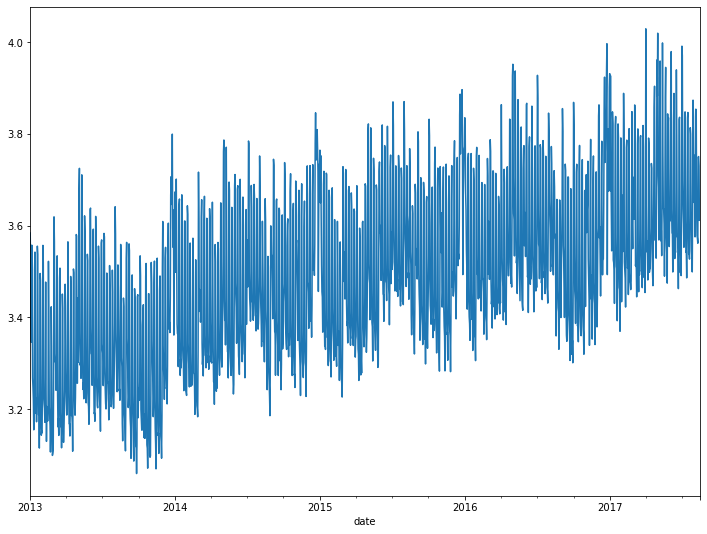

In [14]:
# Let's see the aggregate sales. It seems like data prior to mid-2015 is unreliable.

train.groupby('date')['sales'].mean().plot(figsize=(12, 9))

<AxesSubplot:xlabel='date'>

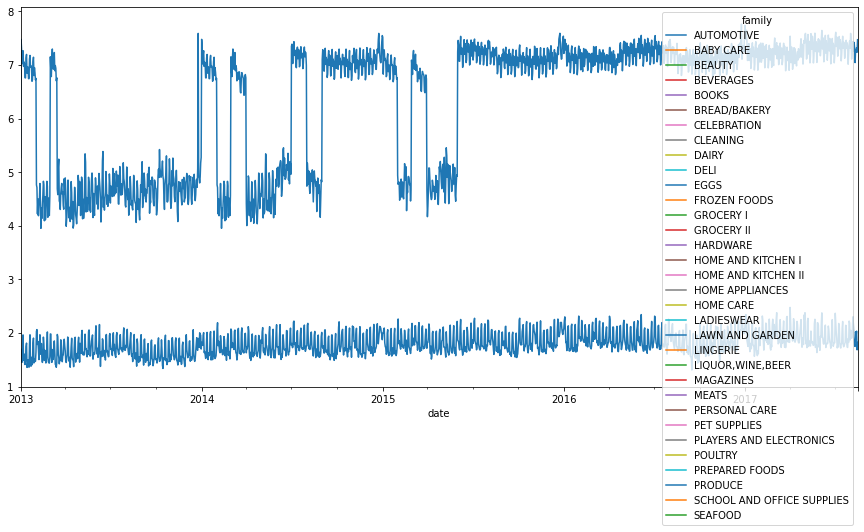

In [15]:
# plot of two arbitrary families, aggregated

fig, ax = plt.subplots(figsize=(15,7))
train[(train['family'] == 'AUTOMOTIVE') | (train['family'] == 'PRODUCE')].groupby(
    ['date','family']).mean()['sales'].unstack().plot(ax=ax)

<AxesSubplot:xlabel='date'>

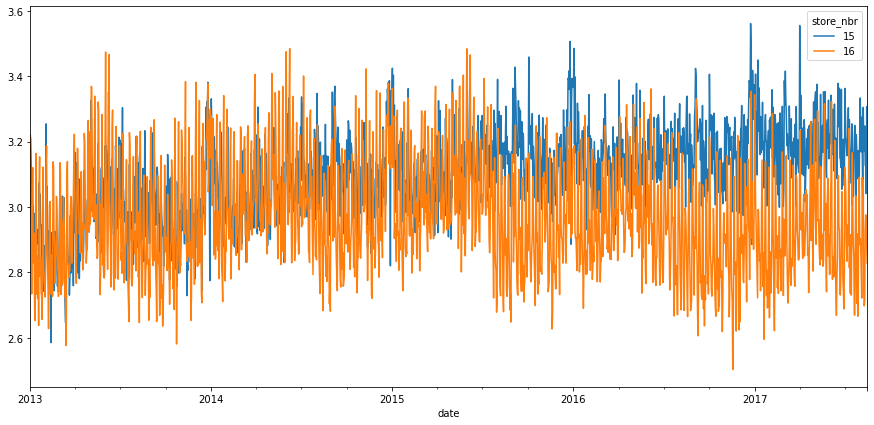

In [16]:
# plot of two stores, across families

fig, ax = plt.subplots(figsize=(15,7))
train[(train['store_nbr'] >= 15) & (train['store_nbr'] <= 16)].groupby(
    ['date','store_nbr']).mean()['sales'].unstack().plot(ax=ax)

## Oil

It is clear that as the oil prices decrease, sales increase. Therefore it should be useful to include the oil dataset.

<AxesSubplot:xlabel='date'>

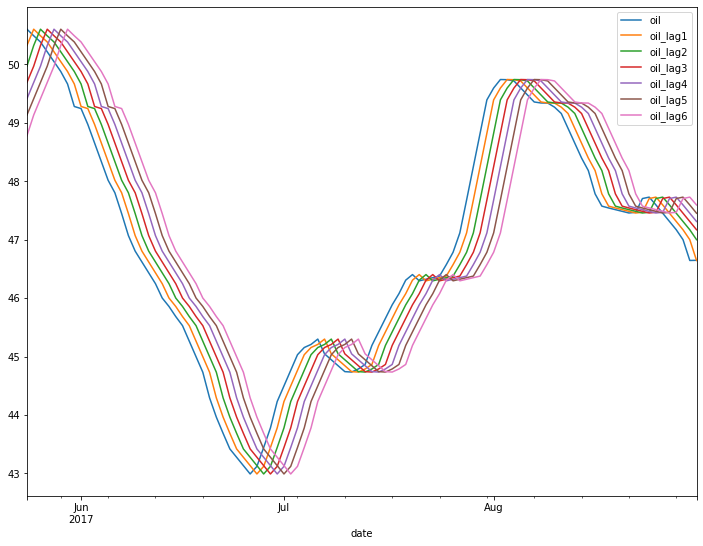

In [17]:
oil[-100:].plot(figsize=(12, 9))

## Create sales lags

In [18]:
train_sales = train.set_index(["store_nbr", "family", "date"]).sort_index()[["sales"]].unstack(
    ['store_nbr', 'family'])
train_sales.shape

(1688, 1782)

In [19]:
test_sales = test.copy()
test_sales['sales'] = np.nan
test_sales = test_sales.set_index(["store_nbr", "family", "date"]).sort_index()[["sales"]].unstack(
    ['store_nbr', 'family'])
test_sales.shape

(16, 1782)

In [20]:
all_sales = pd.concat([train_sales, test_sales])
all_sales.shape

(1704, 1782)

In [21]:
all_sales.head()

sales                                                       \
store_nbr          1                                                         
family     AUTOMOTIVE BABY CARE    BEAUTY BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                         
2013-01-01   1.098612       0.0  0.693147  6.734592  0.693147     5.188285   
2013-01-02   1.098612       0.0  1.098612  6.995766  0.693147     6.156241   
2013-01-03   1.386294       0.0  1.945910  6.824374  0.000000     5.741897   
2013-01-04   1.386294       0.0  1.386294  6.860664  0.000000     5.295142   
2013-01-05   1.791759       0.0  1.386294  7.057037  0.693147     5.710616   

                                                      ...                      \
store_nbr                                             ...        54             
family     CELEBRATION  CLEANING     DAIRY      DELI  ... MAGAZINES     MEATS   
date                                                  ...                       
2013-01-01    2.833213  6.059123  6.084499  4.352134  ...  0.693147  3.561813   
2013-01-02    2.833213  6.966967  6.363028  5.106364  ...  1.098612  4.314430   
2013-01-03    2.564949  6.729824  6.118097  5.027702  ...  0.693147  3.936852   
2013-01-04    3.091042  6.719013  6.133398  4.885911  ...  0.693147  3.718996   
2013-01-05    2.890372  6.699500  6.142037  4.784262  ...  1.386294  3.793937   

                                                                         \
store_nbr                                                                 
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   POULTRY   
date                                                                      
2013-01-01      4.852030     0.000000                1.098612  5.265200   
2013-01-02      5.433722     0.000000                1.945910  2.804209   
2013-01-03      5.056246     0.000000                1.791759  1.670157   
2013-01-04      4.990433     0.693147                2.079442  3.322984   
2013-01-05      5.327876     0.693147                0.693147  3.469417   

                                                                          
store_nbr                                                                 
family     PREPARED FOODS   PRODUCE SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
date                                                                      
2013-01-01       2.302585  6.720547                        0.0  0.693147  
2013-01-02       4.127134  6.610948                        0.0  1.386294  
2013-01-03       0.693147  5.889144                        0.0  1.098612  
2013-01-04       3.663562  5.946496                        0.0  1.098612  
2013-01-05       3.496508  6.107308                        0.0  0.693147  

[5 rows x 1782 columns]

In [22]:
def make_sales_lag(df, N):
    shifted = df.shift(N).fillna(method='bfill')
    shifted.columns = shifted.columns.set_levels([f'sales_lag_{N:02d}'], level=0)
    return pd.concat([df, shifted], axis=1)

def make_sales_lags(df, N_from, N_to):
    shifted_all = []
    for i in range(N_from, N_to): 
        shifted = df.shift(i).fillna(method='bfill')
        shifted.columns = shifted.columns.set_levels([f'sales_lag_{i:02d}'], level=0)
        shifted_all.append(shifted)
    return pd.concat(shifted_all, axis=1)

sales_lags = make_sales_lags(all_sales, 1, max_sales_lags + 1)
sales_lags = sales_lags.stack(['store_nbr', 'family'], dropna=False)
sales_lags = sales_lags.reset_index()
sales_lags.head()

,date,store_nbr,family,sales_lag_01,sales_lag_02,sales_lag_03,sales_lag_04,sales_lag_05,sales_lag_06,sales_lag_07,...,sales_lag_11,sales_lag_12,sales_lag_13,sales_lag_14,sales_lag_15,sales_lag_16,sales_lag_17,sales_lag_18,sales_lag_19,sales_lag_20
0,2013-01-01,1,AUTOMOTIVE,1.098612,1.098612,1.098612,1.098612,1.098612,1.098612,1.098612,...,1.098612,1.098612,1.098612,1.098612,1.098612,1.098612,1.098612,1.098612,1.098612,1.098612
1,2013-01-01,1,BABY CARE,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2013-01-01,1,BEAUTY,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,...,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147
3,2013-01-01,1,BEVERAGES,6.734592,6.734592,6.734592,6.734592,6.734592,6.734592,6.734592,...,6.734592,6.734592,6.734592,6.734592,6.734592,6.734592,6.734592,6.734592,6.734592,6.734592
4,2013-01-01,1,BOOKS,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,...,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147


In [23]:
sales_lags.shape

(3036528, 23)

## Combine All Data

In [24]:
all = pd.merge(pd.concat([train, test]), sales_lags, how="left")

In [25]:
all = pd.merge(all, stores, how='left')

In [26]:
# year/month/week/day features

all['month'] = all.date.dt.month
all['day_of_month'] = all.date.dt.day
all['day_of_year'] = all.date.dt.dayofyear
all['week_of_year'] = all.date.dt.weekofyear
all['day_of_week'] = all.date.dt.dayofweek
all['weekday'] = all.date.dt.dayofweek  # will be one-hot encoded
all['year'] = all.date.dt.year

In [27]:
all = all.merge(holidays_events.groupby('date').first(), how='left', on='date')
all = all.drop(['id'], axis=1)
all['holiday_type'].fillna('None', inplace=True)

In [28]:
all

,date,store_nbr,family,sales,onpromotion,sales_lag_01,sales_lag_02,sales_lag_03,sales_lag_04,sales_lag_05,...,cluster,month,day_of_month,day_of_year,week_of_year,day_of_week,weekday,year,holiday_type,holiday_transferred
0,2013-01-01,1,AUTOMOTIVE,1.098612,0,1.098612,1.098612,1.098612,1.098612,1.098612,...,13,1,1,1,1,1,1,2013,Holiday,False
1,2013-01-01,1,BABY CARE,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,13,1,1,1,1,1,1,2013,Holiday,False
2,2013-01-01,1,BEAUTY,0.693147,0,0.693147,0.693147,0.693147,0.693147,0.693147,...,13,1,1,1,1,1,1,2013,Holiday,False
3,2013-01-01,1,BEVERAGES,6.734592,0,6.734592,6.734592,6.734592,6.734592,6.734592,...,13,1,1,1,1,1,1,2013,Holiday,False
4,2013-01-01,1,BOOKS,0.693147,0,0.693147,0.693147,0.693147,0.693147,0.693147,...,13,1,1,1,1,1,1,2013,Holiday,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3036523,2017-08-31,9,POULTRY,NaN,1,NaN,NaN,NaN,NaN,NaN,...,6,8,31,243,35,3,3,2017,None,NaN
3036524,2017-08-31,9,PREPARED FOODS,NaN,0,NaN,NaN,NaN,NaN,NaN,...,6,8,31,243,35,3,3,2017,None,NaN
3036525,2017-08-31,9,PRODUCE,NaN,1,NaN,NaN,NaN,NaN,NaN,...,6,8,31,243,35,3,3,2017,None,NaN
3036526,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,NaN,NaN,NaN,NaN,NaN,...,6,8,31,243,35,3,3,2017,None,NaN


In [29]:
all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3036528 entries, 0 to 3036527
Data columns (total 38 columns):
 #   Column               Dtype    
---  ------               -----    
 0   date                 period[D]
 1   store_nbr            int64    
 2   family               category 
 3   sales                float64  
 4   onpromotion          int64    
 5   sales_lag_01         float64  
 6   sales_lag_02         float64  
 7   sales_lag_03         float64  
 8   sales_lag_04         float64  
 9   sales_lag_05         float64  
 10  sales_lag_06         float64  
 11  sales_lag_07         float64  
 12  sales_lag_08         float64  
 13  sales_lag_09         float64  
 14  sales_lag_10         float64  
 15  sales_lag_11         float64  
 16  sales_lag_12         float64  
 17  sales_lag_13         float64  
 18  sales_lag_14         float64  
 19  sales_lag_15         float64  
 20  sales_lag_16         float64  
 21  sales_lag_17         float64  
 22  sales_lag_18      

## Export Cleaned Data

In [30]:
all.to_csv('cleaned.csv.gz', index=False, compression='gzip')